In [1]:
# /*==========================================================================================*\ #
# **                        _           _ _   _     _  _         _                            ** #
# **                       | |__  _   _/ | |_| |__ | || |  _ __ | |__                         ** #
# **                       | '_ \| | | | | __| '_ \| || |_| '_ \| '_ \                        ** #
# **                       | |_) | |_| | | |_| | | |__   _| | | | | | |                       ** #
# **                       |_.__/ \__,_|_|\__|_| |_|  |_| |_| |_|_| |_|                       ** #
# \*==========================================================================================*/ #


# -----------------------------------------------------------------------------------------------
# Author: Bùi Tiến Thành - Tien-Thanh Bui (@bu1th4nh)
# Title: LUAD.ipynb
# Date: 2024/11/19 14:33:57
# Description: Preprocess the Lung Cancer dataset
# 
# (c) 2024 bu1th4nh. All rights reserved. 
# Written with dedication in the University of Central Florida, EPCOT and the Magic Kingdom.
# -----------------------------------------------------------------------------------------------


import s3fs
import logging
import numpy as np
import pandas as pd
from tqdm import tqdm
from typing import List, Dict, Any, Tuple, Union, Literal
import ydata_profiling as ydp
import matplotlib.pyplot as plt
import os



# DATA_PATH = '/home/ti514716/Datasets/LungCancer'
# storage_options = None
# s3 = None

TEST_PASS = 100
OVERRIDE_EXISTING_2_OMICS = False
OVERRIDE_EXISTING_3_OMICS = False




DATA_PATH = 's3://datasets/LungCancer'
storage_options = {
    'key': 'bu1th4nh',
    'secret': 'ariel.anna.elsa',
    'endpoint_url': 'http://localhost:9000',
}
s3 = s3fs.S3FileSystem(
    key=storage_options['key'],
    secret=storage_options['secret'],
    endpoint_url=storage_options['endpoint_url'],
    use_ssl=False,
)

/home/ti514716/Venvs/CrossOmics/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Parquet-ize the data
parquetize = False
if s3 is not None:
    if not s3.exists(f'{DATA_PATH}/raw_parquet'):
        s3.makedirs(f'{DATA_PATH}/raw_parquet')
        parquetize = True
else:
    if not os.path.exists(f'{DATA_PATH}/raw_parquet'):
        os.makedirs(f'{DATA_PATH}/raw_parquet')
        parquetize = True


if parquetize:
    pd.read_csv(f'{DATA_PATH}/raw_textfiles/bipartite_targetscan_gene.csv', storage_options=storage_options).to_parquet(f'{DATA_PATH}/raw_parquet/bipartite_targetscan_gene.parquet', storage_options=storage_options)
    pd.read_csv(f'{DATA_PATH}/raw_textfiles/luad_tcga_pan_can_atlas_2018_clinical_data.tsv', sep='\t', storage_options=storage_options).to_parquet(f'{DATA_PATH}/raw_parquet/luad_clinical.parquet', storage_options=storage_options)
    pd.read_csv(f'{DATA_PATH}/raw_textfiles/DNAMethyl_LUAD_450k', sep='\t', storage_options=storage_options).to_parquet(f'{DATA_PATH}/raw_parquet/methDNA.parquet', storage_options=storage_options)
    pd.read_csv(f'{DATA_PATH}/raw_textfiles/miRNA_HiSeq_gene', sep='\t', storage_options=storage_options).to_parquet(f'{DATA_PATH}/raw_parquet/miRNA.parquet', storage_options=storage_options)
    pd.read_csv(f'{DATA_PATH}/raw_textfiles/mRNA_HiSeqV2', sep='\t', storage_options=storage_options).to_parquet(f'{DATA_PATH}/raw_parquet/mRNA.parquet', storage_options=storage_options)


# Data Acquisition

In [2]:
raw_bipart_data = pd.read_parquet(f'{DATA_PATH}/raw_parquet/bipartite_targetscan_gene.parquet', storage_options=storage_options)
raw_clinical = pd.read_parquet(f'{DATA_PATH}/raw_parquet/luad_clinical.parquet', storage_options=storage_options)
raw_methDNA = pd.read_parquet(f'{DATA_PATH}/raw_parquet/methDNA.parquet', storage_options=storage_options)
raw_miRNA = pd.read_parquet(f'{DATA_PATH}/raw_parquet/miRNA.parquet', storage_options=storage_options)
raw_mRNA = pd.read_parquet(f'{DATA_PATH}/raw_parquet/mRNA.parquet', storage_options=storage_options)

# Elementary Data Analysis

### mRNA, miRNA, and methylation data

In [3]:
# Sampling
display(raw_mRNA.head())
display(raw_miRNA.head())
display(raw_methDNA.head())

,sample,TCGA-69-7978-01,TCGA-62-8399-01,TCGA-78-7539-01,TCGA-50-5931-11,TCGA-73-4658-01,TCGA-44-6775-01,TCGA-44-2655-01,TCGA-44-3398-01,TCGA-62-8397-01,...,TCGA-75-7025-01,TCGA-55-7726-01,TCGA-L9-A743-01,TCGA-86-8358-01,TCGA-55-6972-01,TCGA-55-7727-01,TCGA-91-6831-01,TCGA-MN-A4N4-01,TCGA-55-8302-01,TCGA-MP-A4TK-01
0,ARHGEF10L,9.9898,10.4257,9.6264,8.6835,9.2078,10.0039,9.3263,9.0249,10.5411,...,10.0905,7.5219,9.6563,9.2042,8.2127,7.2428,8.8388,9.9341,10.1696,10.1272
1,HIF3A,4.2598,11.6239,9.1362,9.4824,5.0288,4.0573,5.5335,5.7347,6.6477,...,8.0944,4.2952,5.1675,9.2442,9.0641,7.5416,3.5613,8.3457,5.5364,10.2122
2,RNF17,0.4181,0.0000,1.1231,0.8221,0.0000,1.0069,0.6021,0.0000,0.0000,...,0.4628,0.0000,0.9593,0.7339,1.0987,0.9392,0.0000,0.9715,0.0000,0.5804
3,RNF10,10.3657,11.5489,11.6692,11.7341,11.6209,11.1721,11.9169,11.3274,12.3611,...,11.3260,12.0388,11.4458,11.5642,11.5881,11.8686,12.2704,11.8150,11.7813,11.4430
4,RNF11,11.1718,11.0200,10.4679,11.6787,11.3414,11.0969,11.4044,11.4975,11.2828,...,10.8121,11.3304,10.4473,10.9991,10.0014,11.2862,11.1187,10.6101,10.5163,11.1243


,sample,TCGA-NJ-A4YP-01,TCGA-86-8278-01,TCGA-62-A470-01,TCGA-44-6778-01,TCGA-49-AARQ-01,TCGA-97-A4M1-01,TCGA-99-8033-01,TCGA-44-3398-11,TCGA-78-7149-01,...,TCGA-78-7152-01,TCGA-78-7539-01,TCGA-62-A46S-01,TCGA-95-7947-01,TCGA-J2-8192-01,TCGA-78-7145-01,TCGA-50-6593-01,TCGA-69-7973-01,TCGA-86-7713-01,TCGA-55-8302-01
0,MIMAT0019868,NaN,NaN,NaN,NaN,NaN,NaN,0.2515,NaN,NaN,...,NaN,NaN,NaN,0.331,NaN,NaN,0.2143,0.2125,NaN,NaN
1,MIMAT0019869,NaN,NaN,NaN,NaN,NaN,0.493416,NaN,0.7525,NaN,...,NaN,NaN,0.327,NaN,NaN,0.2193,0.2143,NaN,0.3608,NaN
2,MIMAT0019860,NaN,NaN,NaN,0.3516,NaN,NaN,0.2515,NaN,NaN,...,NaN,NaN,NaN,0.331,NaN,NaN,NaN,NaN,0.3608,NaN
3,MIMAT0019861,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,MIMAT0019862,NaN,0.1532,NaN,0.3516,0.903098,NaN,0.2515,NaN,NaN,...,0.2944,0.2755,0.327,NaN,NaN,0.2193,NaN,0.2125,NaN,NaN


,sample,TCGA-44-4112-01,TCGA-NJ-A4YP-01,TCGA-86-8278-01,TCGA-62-A470-01,TCGA-44-6778-01,TCGA-49-AARQ-01,TCGA-97-A4M1-01,TCGA-55-6975-01,TCGA-99-8033-01,...,TCGA-78-7539-01,TCGA-62-A46S-01,TCGA-95-7947-01,TCGA-J2-8192-01,TCGA-78-7145-01,TCGA-50-6593-01,TCGA-69-7973-01,TCGA-50-6591-11,TCGA-86-7713-01,TCGA-55-8302-01
0,cg13332474,0.06685,0.3178,0.4128,0.0397,0.0315,0.6965,0.0153,0.0257,0.0296,...,0.0457,0.0592,0.4546,0.0372,0.4626,0.2181,0.0309,0.0417,0.0217,0.3117
1,cg00651829,0.09115,0.2879,0.4702,0.0616,0.0424,0.0226,0.0233,0.0285,0.0210,...,0.0169,0.0463,0.0226,0.0222,0.3296,0.1885,0.0300,0.0369,0.0211,0.4026
2,cg17027195,0.03115,0.1224,0.0446,0.0292,0.0365,0.0780,0.0501,0.0737,0.0167,...,0.0259,0.0584,0.0061,0.0187,0.0472,0.0899,0.0505,0.0428,0.0454,0.0337
3,cg09868354,0.05725,0.1316,0.1409,0.0776,0.0600,0.1044,0.0888,0.0527,0.0434,...,0.1067,0.0723,0.0475,0.0496,0.1568,0.0808,0.0503,0.1159,0.0689,0.1147
4,cg03050183,0.15125,0.1107,0.1082,0.1142,0.0893,0.1220,0.1118,0.1468,0.1109,...,0.1287,0.1196,0.0937,0.1077,0.1045,0.1611,0.0949,0.1500,0.1284,0.1141


In [4]:
# Shape
print(f'mRNA shape: {raw_mRNA.shape[0]} rows and {raw_mRNA.shape[1]} columns')
print(f'miRNA shape: {raw_miRNA.shape[0]} rows and {raw_miRNA.shape[1]} columns')
print(f'methDNA shape: {raw_methDNA.shape[0]} rows and {raw_methDNA.shape[1]} columns')

mRNA shape: 20530 rows and 577 columns
miRNA shape: 2228 rows and 496 columns
methDNA shape: 485577 rows and 493 columns


In [6]:
# Columns
print(f'mRNA columns: {len(raw_mRNA.columns)}  :  {list(raw_mRNA.columns)}')
print(f'miRNA columns: {len(raw_miRNA.columns)}  :  {list(raw_miRNA.columns)}')
print(f'methDNA columns: {len(raw_methDNA.columns)}  :  {list(raw_methDNA.columns)}')
print()
# Sample Intersection
Ariel = set(raw_mRNA.columns) & set(raw_miRNA.columns) & set(raw_methDNA.columns)
print(f'Intersection all  {len(Ariel)}  :  {Ariel}')
print()
Ariel = set(raw_mRNA.columns) & set(raw_miRNA.columns)
print(f'Intersection mRNA and miRNA  {len(Ariel)}  :  {Ariel}')
Ariel = set(raw_mRNA.columns) & set(raw_methDNA.columns)
print(f'Intersection mRNA and methDNA  {len(Ariel)}  :  {Ariel}')
Ariel = set(raw_miRNA.columns) & set(raw_methDNA.columns)
print(f'Intersection miRNA and methDNA  {len(Ariel)}  :  {Ariel}')


# Sample Difference
Ariel = set(raw_mRNA.columns) - set(raw_miRNA.columns)
print(f'Sample Difference mRNA and miRNA  {len(Ariel)}  :  {Ariel}')
Ariel = set(raw_miRNA.columns) - set(raw_mRNA.columns)
print(f'Sample Difference miRNA and mRNA  {len(Ariel)}  :  {Ariel}')

Ariel = set(raw_methDNA.columns) - set(raw_miRNA.columns)
print(f'Sample Difference methDNA and miRNA  {len(Ariel)}  :  {Ariel}')
Ariel = set(raw_miRNA.columns) - set(raw_methDNA.columns)
print(f'Sample Difference miRNA and methDNA  {len(Ariel)}  :  {Ariel}')

Ariel = set(raw_methDNA.columns) - set(raw_mRNA.columns)
print(f'Sample Difference methDNA and mRNA  {len(Ariel)}  :  {Ariel}')
Ariel = set(raw_mRNA.columns) - set(raw_methDNA.columns)
print(f'Sample Difference mRNA and methDNA  {len(Ariel)}  :  {Ariel}')


mRNA columns: 577  :  ['sample', 'TCGA-69-7978-01', 'TCGA-62-8399-01', 'TCGA-78-7539-01', 'TCGA-50-5931-11', 'TCGA-73-4658-01', 'TCGA-44-6775-01', 'TCGA-44-2655-01', 'TCGA-44-3398-01', 'TCGA-62-8397-01', 'TCGA-53-A4EZ-01', 'TCGA-50-7109-01', 'TCGA-38-6178-01', 'TCGA-86-8056-01', 'TCGA-55-1592-01', 'TCGA-86-A4JF-01', 'TCGA-69-7974-01', 'TCGA-86-A456-01', 'TCGA-49-4512-11', 'TCGA-97-8547-01', 'TCGA-55-1595-01', 'TCGA-49-6743-11', 'TCGA-NJ-A4YP-01', 'TCGA-05-4424-01', 'TCGA-97-A4M7-01', 'TCGA-44-2668-01', 'TCGA-NJ-A55A-01', 'TCGA-44-6148-11', 'TCGA-50-5939-11', 'TCGA-05-5420-01', 'TCGA-55-1594-01', 'TCGA-44-2659-01', 'TCGA-78-7162-01', 'TCGA-38-4632-01', 'TCGA-49-6761-01', 'TCGA-91-6828-01', 'TCGA-05-4418-01', 'TCGA-99-AA5R-01', 'TCGA-55-7903-01', 'TCGA-55-A492-01', 'TCGA-55-8616-01', 'TCGA-86-7954-01', 'TCGA-05-4433-01', 'TCGA-69-8253-01', 'TCGA-86-8674-01', 'TCGA-69-7765-01', 'TCGA-86-8672-01', 'TCGA-MP-A4T6-01', 'TCGA-97-7547-01', 'TCGA-55-7911-01', 'TCGA-91-6835-01', 'TCGA-55-6984-11'

In [7]:
# 1st columns - mRNA/miRNA value
# Why 'sample'? Because of Pandas' read_csv mechanism. It is not very intuitive, but it is what it is.
mRNA_for_genes = raw_mRNA['sample']
miRNA_for_genes = raw_miRNA['sample']
methDNA_for_genes = raw_methDNA['sample']

print(f'mRNAs: {len(mRNA_for_genes)} :  {list(mRNA_for_genes)}')
print(f'miRNAs: {len(miRNA_for_genes)} :  {list(miRNA_for_genes)}')
print(f'methDNAs: {len(methDNA_for_genes)} :  {list(methDNA_for_genes)[:100]}')

mRNAs: 20530 :  ['ARHGEF10L', 'HIF3A', 'RNF17', 'RNF10', 'RNF11', 'RNF13', 'GTF2IP1', 'REM1', 'MTVR2', 'RTN4RL2', 'C16orf13', 'C16orf11', 'FGFR1OP2', 'TSKS', 'ATRX', 'PMM2', 'LOC100272146', 'ASS1', 'NCBP1', 'ZNF709', 'ZNF708', 'RBM14', 'NCBP2', 'DISC1', 'CAMK1', 'RPL37', 'SPR', 'ZNF700', 'ZNF707', 'CAMK4', 'ZNF704', 'LOC339240', 'GOLGA6B', 'RNF115', 'RNF112', 'ZC3H14', 'SPN', 'HMGCLL1', 'NACAP1', 'LRRTM1', 'GRIN1', 'RBMY1A3P', 'DHX8', 'DHX9', 'LOC441204', 'TCOF1', 'LRRTM3', 'NUP98', 'XPC', 'SLC12A2', 'GRINA', 'LRRTM2', 'NUP93', 'HAP1', 'KLRA1', 'CAMKV', 'SPPL3', 'GOLIM4', 'ZNF646', 'OPA3', 'OPA1', 'RHEB', 'RAB40C', 'RAB40B', 'RAB40A', 'COL7A1', 'MDP1', 'GTSE1', 'FAM183A', 'ARFRP1', 'OVCH1', 'FAM183B', 'PSAP', 'KIAA0831', 'SPPL2A', 'SLC46A1', 'TGFBR2', 'ITGA8', 'ITGA9', 'STK40', 'MYO3B', 'ATP2A1', 'ATP2A2', 'ATP2A3', 'ITGA1', 'ITGA2', 'ITGA3', 'ITGA4', 'ITGA5', 'ITGA6', 'ITGA7', 'TRHR', 'LOC100132288', 'DENND4A', 'DENND4B', 'DENND4C', 'SWAP70', 'RARRES1', 'LOC100132287', 'PHLDA3', 'PHLD

### Bipatitite Data mRNAs and miRNAs

In [8]:
# Sampling
display(raw_bipart_data.head())

,gene_name,MIMAT0000441,MIMAT0000755,MIMAT0000250,MIMAT0000064,MIMAT0000098,MIMAT0000075,MIMAT0000732,MIMAT0002834,MIMAT0000255,...,MIMAT0002172,MIMAT0000736,MIMAT0000252,MIMAT0000770,MIMAT0001545,MIMAT0000692,MIMAT0000753,MIMAT0000450,MIMAT0000081,MIMAT0000281
0,ARF5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,M6PR,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,FKBP4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,CYP26B1,0,0,0,0,1,1,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,FUCA2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# Shape
print(f'bipart_data shape: {raw_bipart_data.shape[0]} rows and {raw_bipart_data.shape[1]} columns')
print()

# Columns
print(f'bipart_data columns: {len(raw_bipart_data.columns)}  :  {list(raw_bipart_data.columns)}')
print()

# 1st column - mRNAs aka 'rows'
mRNA_bipart = raw_bipart_data['gene_name']   
print(f'mRNA: {len(mRNA_bipart)} :  {list(mRNA_bipart)}')

bipart_data shape: 11329 rows and 280 columns

bipart_data columns: 280  :  ['gene_name', 'MIMAT0000441', 'MIMAT0000755', 'MIMAT0000250', 'MIMAT0000064', 'MIMAT0000098', 'MIMAT0000075', 'MIMAT0000732', 'MIMAT0002834', 'MIMAT0000255', 'MIMAT0000278', 'MIMAT0000076', 'MIMAT0000269', 'MIMAT0002819', 'MIMAT0002878', 'MIMAT0000758', 'MIMAT0000452', 'MIMAT0022726', 'MIMAT0000083', 'MIMAT0000266', 'MIMAT0002856', 'MIMAT0000074', 'MIMAT0000416', 'MIMAT0003331', 'MIMAT0002853', 'MIMAT0001536', 'MIMAT0000447', 'MIMAT0003233', 'MIMAT0005796', 'MIMAT0004774', 'MIMAT0004564', 'MIMAT0000091', 'MIMAT0000458', 'MIMAT0000093', 'MIMAT0000707', 'MIMAT0000092', 'MIMAT0000765', 'MIMAT0000430', 'MIMAT0001631', 'MIMAT0001625', 'MIMAT0001341', 'MIMAT0002846', 'MIMAT0022697', 'MIMAT0027571', 'MIMAT0000254', 'MIMAT0000617', 'MIMAT0004955', 'MIMAT0000096', 'MIMAT0000425', 'MIMAT0000721', 'MIMAT0005793', 'MIMAT0000737', 'MIMAT0002177', 'MIMAT0000761', 'MIMAT0000078', 'MIMAT0000085', 'MIMAT0004952', 'MIMAT0000448'

### Clinical Data

In [10]:
# Sampling
display(raw_clinical.head())

,Study ID,Patient ID,Sample ID,Diagnosis Age,Neoplasm Disease Stage American Joint Committee on Cancer Code,American Joint Committee on Cancer Publication Version Type,Aneuploidy Score,Buffa Hypoxia Score,Cancer Type,TCGA PanCanAtlas Cancer Type Acronym,...,Subtype,Tissue Prospective Collection Indicator,Tissue Retrospective Collection Indicator,Tissue Source Site,Tissue Source Site Code,TMB (nonsynonymous),Tumor Disease Anatomic Site,Tumor Type,Patient Weight,Winter Hypoxia Score
0,luad_tcga_pan_can_atlas_2018,TCGA-05-4244,TCGA-05-4244-01,70.0,STAGE IV,6TH,17.0,11.0,Non-Small Cell Lung Cancer,LUAD,...,LUAD,No,Yes,Indivumed,5,6.400000,Lung,Lung Adenocarcinoma (NOS),NaN,20.0
1,luad_tcga_pan_can_atlas_2018,TCGA-05-4249,TCGA-05-4249-01,67.0,STAGE IB,6TH,24.0,-27.0,Non-Small Cell Lung Cancer,LUAD,...,LUAD,No,Yes,Indivumed,5,10.000000,Lung,Lung Adenocarcinoma (NOS),NaN,-26.0
2,luad_tcga_pan_can_atlas_2018,TCGA-05-4250,TCGA-05-4250-01,79.0,STAGE IIIA,6TH,17.0,29.0,Non-Small Cell Lung Cancer,LUAD,...,LUAD,No,Yes,Indivumed,5,10.500000,Lung,Lung Adenocarcinoma (NOS),NaN,32.0
3,luad_tcga_pan_can_atlas_2018,TCGA-05-4382,TCGA-05-4382-01,68.0,STAGE IB,6TH,22.0,19.0,Non-Small Cell Lung Cancer,LUAD,...,LUAD,No,Yes,Indivumed,5,51.733333,Lung,"Lung Adenocarcinoma, Mixed Subtype",NaN,34.0
4,luad_tcga_pan_can_atlas_2018,TCGA-05-4384,TCGA-05-4384-01,66.0,STAGE IIIA,6TH,1.0,-37.0,Non-Small Cell Lung Cancer,LUAD,...,LUAD,No,Yes,Indivumed,5,3.966667,Lung,"Lung Adenocarcinoma, Mixed Subtype",NaN,-24.0


In [12]:
# Shape
print(f'clinical shape: {raw_clinical.shape[0]} rows and {raw_clinical.shape[1]} columns')
print()

# Columns
print(f'clinical columns: {len(raw_clinical.columns)}  :  {list(raw_clinical.columns)}')
print()


clinical shape: 566 rows and 62 columns

clinical columns: 62  :  ['Study ID', 'Patient ID', 'Sample ID', 'Diagnosis Age', 'Neoplasm Disease Stage American Joint Committee on Cancer Code', 'American Joint Committee on Cancer Publication Version Type', 'Aneuploidy Score', 'Buffa Hypoxia Score', 'Cancer Type', 'TCGA PanCanAtlas Cancer Type Acronym', 'Cancer Type Detailed', 'Last Communication Contact from Initial Pathologic Diagnosis Date', 'Birth from Initial Pathologic Diagnosis Date', 'Last Alive Less Initial Pathologic Diagnosis Date Calculated Day Value', 'Disease Free (Months)', 'Disease Free Status', 'Months of disease-specific survival', 'Disease-specific Survival status', 'Ethnicity Category', 'Form completion date', 'Fraction Genome Altered', 'Genetic Ancestry Label', 'Neoplasm Histologic Grade', 'Neoadjuvant Therapy Type Administered Prior To Resection Text', 'ICD-10 Classification', 'International Classification of Diseases for Oncology, Third Edition ICD-O-3 Histology Code',

# Aligning data to correct format

### mRNA

Sample,TCGA-69-7978-01,TCGA-62-8399-01,TCGA-78-7539-01,TCGA-50-5931-11,TCGA-73-4658-01,TCGA-44-6775-01,TCGA-44-2655-01,TCGA-44-3398-01,TCGA-62-8397-01,TCGA-53-A4EZ-01,...,TCGA-75-7025-01,TCGA-55-7726-01,TCGA-L9-A743-01,TCGA-86-8358-01,TCGA-55-6972-01,TCGA-55-7727-01,TCGA-91-6831-01,TCGA-MN-A4N4-01,TCGA-55-8302-01,TCGA-MP-A4TK-01
mRNA_ID,,,,,,,,,,,,,,,,,,,,,
ARHGEF10L,9.9898,10.4257,9.6264,8.6835,9.2078,10.0039,9.3263,9.0249,10.5411,10.8969,...,10.0905,7.5219,9.6563,9.2042,8.2127,7.2428,8.8388,9.9341,10.1696,10.1272
HIF3A,4.2598,11.6239,9.1362,9.4824,5.0288,4.0573,5.5335,5.7347,6.6477,8.0041,...,8.0944,4.2952,5.1675,9.2442,9.0641,7.5416,3.5613,8.3457,5.5364,10.2122
RNF17,0.4181,0.0000,1.1231,0.8221,0.0000,1.0069,0.6021,0.0000,0.0000,0.0000,...,0.4628,0.0000,0.9593,0.7339,1.0987,0.9392,0.0000,0.9715,0.0000,0.5804
RNF10,10.3657,11.5489,11.6692,11.7341,11.6209,11.1721,11.9169,11.3274,12.3611,12.3762,...,11.3260,12.0388,11.4458,11.5642,11.5881,11.8686,12.2704,11.8150,11.7813,11.4430
RNF11,11.1718,11.0200,10.4679,11.6787,11.3414,11.0969,11.4044,11.4975,11.2828,10.3068,...,10.8121,11.3304,10.4473,10.9991,10.0014,11.2862,11.1187,10.6101,10.5163,11.1243


332 features in mRNA have all zero values
mRNA shape: 20198 mRNAs and 576 samples


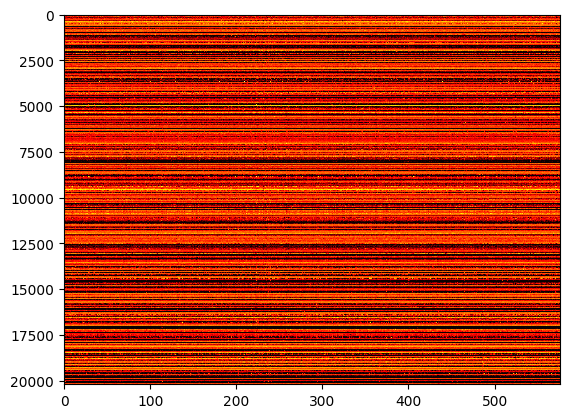

In [5]:
mRNA = raw_mRNA.copy(deep=True)

# Rename first column as 'mRNA ID'
mRNA.rename(columns = {'sample':'mRNA_ID'}, inplace = True)

# Set index as 'mRNA_ID'
mRNA.set_index('mRNA_ID', inplace = True)

# Rename the 'columns' row as 'Sample'
mRNA.columns.name = 'Sample'

# Fill-NA - 0
mRNA.fillna(0, inplace=True)

# Sampling again
display(mRNA.head())

# Zero features
zero_features = []
for feature in mRNA.index:
    if(np.all(mRNA.loc[feature].values == 0)):
        zero_features.append(feature)
print(f'{len(zero_features)} features in mRNA have all zero values')

# Drop zero features
mRNA.drop(zero_features, inplace=True, axis=0)

# Final shape
print(f'mRNA shape: {mRNA.shape[0]} mRNAs and {mRNA.shape[1]} samples')

# Heatmap
plt.imshow(mRNA, cmap='hot', interpolation='nearest', aspect='auto')
plt.show()

### miRNA

Sample,TCGA-NJ-A4YP-01,TCGA-86-8278-01,TCGA-62-A470-01,TCGA-44-6778-01,TCGA-49-AARQ-01,TCGA-97-A4M1-01,TCGA-99-8033-01,TCGA-44-3398-11,TCGA-78-7149-01,TCGA-50-6597-01,...,TCGA-78-7152-01,TCGA-78-7539-01,TCGA-62-A46S-01,TCGA-95-7947-01,TCGA-J2-8192-01,TCGA-78-7145-01,TCGA-50-6593-01,TCGA-69-7973-01,TCGA-86-7713-01,TCGA-55-8302-01
miRNA_ID,,,,,,,,,,,,,,,,,,,,,
MIMAT0019868,0.0,0.0000,0.0,0.0000,0.000000,0.000000,0.2515,0.0000,0.0,0.692803,...,0.0000,0.0000,0.000,0.331,0.0,0.0000,0.2143,0.2125,0.0000,0.0
MIMAT0019869,0.0,0.0000,0.0,0.0000,0.000000,0.493416,0.0000,0.7525,0.0,0.496700,...,0.0000,0.0000,0.327,0.000,0.0,0.2193,0.2143,0.0000,0.3608,0.0
MIMAT0019860,0.0,0.0000,0.0,0.3516,0.000000,0.000000,0.2515,0.0000,0.0,0.000000,...,0.0000,0.0000,0.000,0.331,0.0,0.0000,0.0000,0.0000,0.3608,0.0
MIMAT0019861,0.0,0.0000,0.0,0.0000,0.000000,0.000000,0.0000,0.0000,0.0,0.000000,...,0.0000,0.0000,0.000,0.000,0.0,0.0000,0.0000,0.0000,0.0000,0.0
MIMAT0019862,0.0,0.1532,0.0,0.3516,0.903098,0.000000,0.2515,0.0000,0.0,1.019606,...,0.2944,0.2755,0.327,0.000,0.0,0.2193,0.0000,0.2125,0.0000,0.0


0 features in miRNA have all zero values
miRNA shape: 2228 miRNAs and 495 samples


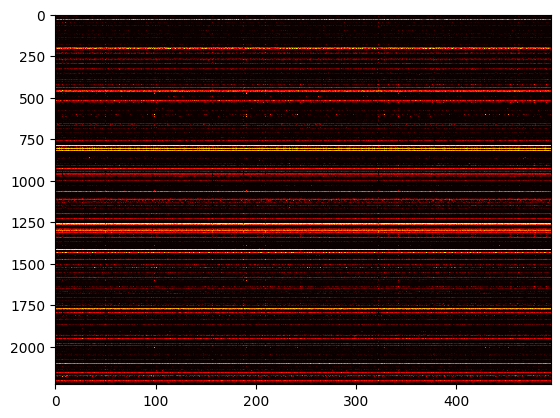

In [6]:
miRNA = raw_miRNA.copy(deep=True)

# Rename first column as 'miRNA ID'
miRNA.rename(columns = {'sample':'miRNA_ID'}, inplace = True)

# Set index as 'miRNA_ID'
miRNA.set_index('miRNA_ID', inplace = True)

# Rename the 'columns' row as 'Sample'
miRNA.columns.name = 'Sample'

# Fill-NA - 0
miRNA.fillna(0, inplace=True)

# Sampling again
display(miRNA.head())

# Zero features
zero_features = []
for feature in miRNA.index:
    if(np.all(miRNA.loc[feature].values == 0)):
        zero_features.append(feature)
print(f'{len(zero_features)} features in miRNA have all zero values')

# Drop zero features
miRNA.drop(zero_features, inplace=True, axis=0)

# Final shape
print(f'miRNA shape: {miRNA.shape[0]} miRNAs and {miRNA.shape[1]} samples')

# Heatmap
plt.imshow(miRNA, cmap='hot', interpolation='nearest', aspect='auto')
plt.show()

### DNA Methylation

Sample,TCGA-44-4112-01,TCGA-NJ-A4YP-01,TCGA-86-8278-01,TCGA-62-A470-01,TCGA-44-6778-01,TCGA-49-AARQ-01,TCGA-97-A4M1-01,TCGA-55-6975-01,TCGA-99-8033-01,TCGA-78-7149-01,...,TCGA-78-7539-01,TCGA-62-A46S-01,TCGA-95-7947-01,TCGA-J2-8192-01,TCGA-78-7145-01,TCGA-50-6593-01,TCGA-69-7973-01,TCGA-50-6591-11,TCGA-86-7713-01,TCGA-55-8302-01
methDNA_ID,,,,,,,,,,,,,,,,,,,,,
cg13332474,0.06685,0.3178,0.4128,0.0397,0.0315,0.6965,0.0153,0.0257,0.0296,0.0332,...,0.0457,0.0592,0.4546,0.0372,0.4626,0.2181,0.0309,0.0417,0.0217,0.3117
cg00651829,0.09115,0.2879,0.4702,0.0616,0.0424,0.0226,0.0233,0.0285,0.0210,0.3545,...,0.0169,0.0463,0.0226,0.0222,0.3296,0.1885,0.0300,0.0369,0.0211,0.4026
cg17027195,0.03115,0.1224,0.0446,0.0292,0.0365,0.0780,0.0501,0.0737,0.0167,0.0753,...,0.0259,0.0584,0.0061,0.0187,0.0472,0.0899,0.0505,0.0428,0.0454,0.0337
cg09868354,0.05725,0.1316,0.1409,0.0776,0.0600,0.1044,0.0888,0.0527,0.0434,0.0805,...,0.1067,0.0723,0.0475,0.0496,0.1568,0.0808,0.0503,0.1159,0.0689,0.1147
cg03050183,0.15125,0.1107,0.1082,0.1142,0.0893,0.1220,0.1118,0.1468,0.1109,0.1071,...,0.1287,0.1196,0.0937,0.1077,0.1045,0.1611,0.0949,0.1500,0.1284,0.1141


Zero features calculation: 100%|██████████| 485577/485577 [00:17<00:00, 27751.68it/s]


89512 features in methDNA have all zero values
methDNA shape: 10480 methDNAs and 492 samples


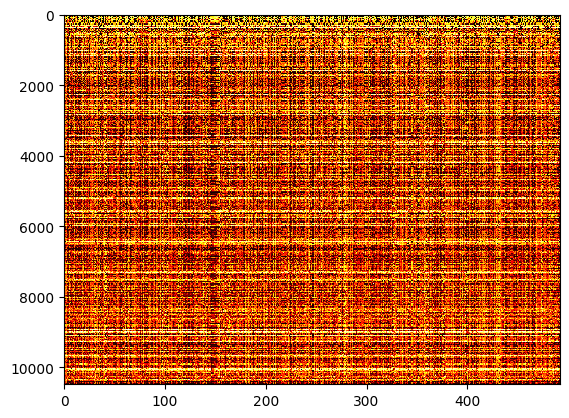

In [7]:
methDNA = raw_methDNA.copy(deep=True)

# Rename first column as 'methDNA ID'
methDNA.rename(columns = {'sample':'methDNA_ID'}, inplace = True)

# Set index as 'methDNA_ID'
methDNA.set_index('methDNA_ID', inplace = True)

# Rename the 'columns' row as 'Sample'
methDNA.columns.name = 'Sample'

# Fill-NA - 0
methDNA.fillna(0, inplace=True)

# Sampling again
display(methDNA.head())

# Zero features
zero_features = []
for feature in tqdm(methDNA.index, desc='Zero features calculation'):
    if(np.all(methDNA.loc[feature].values == 0)):
        zero_features.append(feature)
print(f'{len(zero_features)} features in methDNA have all zero values')

# Drop zero features
methDNA.drop(zero_features, inplace=True, axis=0)

# Top hi-variant features
Ariel = methDNA.var(axis=1).sort_values(ascending=False).head(10480)
methDNA = methDNA.loc[Ariel.index].copy(deep=True)

# Final shape
print(f'methDNA shape: {methDNA.shape[0]} methDNAs and {methDNA.shape[1]} samples')

# Heatmap
plt.imshow(methDNA, cmap='hot', interpolation='nearest', aspect='auto')
plt.show()

### Bipartite Graph

miRNA_ID,MIMAT0000441,MIMAT0000755,MIMAT0000250,MIMAT0000064,MIMAT0000098,MIMAT0000075,MIMAT0000732,MIMAT0002834,MIMAT0000255,MIMAT0000278,...,MIMAT0002172,MIMAT0000736,MIMAT0000252,MIMAT0000770,MIMAT0001545,MIMAT0000692,MIMAT0000753,MIMAT0000450,MIMAT0000081,MIMAT0000281
mRNA_ID,,,,,,,,,,,,,,,,,,,,,
ARF5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
M6PR,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
FKBP4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CYP26B1,0,0,0,0,1,1,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
FUCA2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Bipart shape: 11329 mRNAs and 279 miRNAs


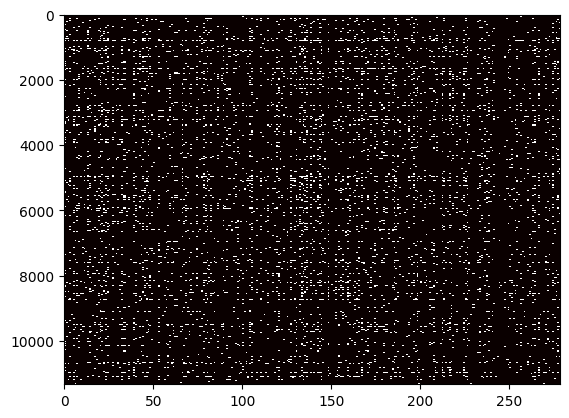

In [8]:
bipart = raw_bipart_data.copy(deep=True)

# Rename first column ('gene_name') as 'mRNA ID'
bipart.rename(columns = {'gene_name':'mRNA_ID'}, inplace = True)

# Set index as 'mRNA_ID'
bipart.set_index('mRNA_ID', inplace = True)

# Rename the 'columns' row as 'miRNA_ID'
bipart.columns.name = 'miRNA_ID'

# Sampling again
display(bipart.head())

# Final shape
print(f'Bipart shape: {bipart.shape[0]} mRNAs and {bipart.shape[1]} miRNAs')

# Heatmap
plt.imshow(bipart, cmap='hot', interpolation='nearest', aspect='auto')
plt.show()

### Clinical Data

In [9]:
clinical = raw_clinical.copy(deep=True)

# Rename first column as 'Sample'
clinical.rename(columns = {'Sample ID': 'Sample'}, inplace = True)

# Set index as 'Sample'
clinical.set_index('Sample', inplace = True)

# Display
display(clinical.head())

# Final shape
print(f'Clinical shape: {clinical.shape[0]} samples and {clinical.shape[1]} features as {list(clinical.columns)}')

,Study ID,Patient ID,Diagnosis Age,Neoplasm Disease Stage American Joint Committee on Cancer Code,American Joint Committee on Cancer Publication Version Type,Aneuploidy Score,Buffa Hypoxia Score,Cancer Type,TCGA PanCanAtlas Cancer Type Acronym,Cancer Type Detailed,...,Subtype,Tissue Prospective Collection Indicator,Tissue Retrospective Collection Indicator,Tissue Source Site,Tissue Source Site Code,TMB (nonsynonymous),Tumor Disease Anatomic Site,Tumor Type,Patient Weight,Winter Hypoxia Score
Sample,,,,,,,,,,,,,,,,,,,,,
TCGA-05-4244-01,luad_tcga_pan_can_atlas_2018,TCGA-05-4244,70.0,STAGE IV,6TH,17.0,11.0,Non-Small Cell Lung Cancer,LUAD,Lung Adenocarcinoma,...,LUAD,No,Yes,Indivumed,5,6.400000,Lung,Lung Adenocarcinoma (NOS),NaN,20.0
TCGA-05-4249-01,luad_tcga_pan_can_atlas_2018,TCGA-05-4249,67.0,STAGE IB,6TH,24.0,-27.0,Non-Small Cell Lung Cancer,LUAD,Lung Adenocarcinoma,...,LUAD,No,Yes,Indivumed,5,10.000000,Lung,Lung Adenocarcinoma (NOS),NaN,-26.0
TCGA-05-4250-01,luad_tcga_pan_can_atlas_2018,TCGA-05-4250,79.0,STAGE IIIA,6TH,17.0,29.0,Non-Small Cell Lung Cancer,LUAD,Lung Adenocarcinoma,...,LUAD,No,Yes,Indivumed,5,10.500000,Lung,Lung Adenocarcinoma (NOS),NaN,32.0
TCGA-05-4382-01,luad_tcga_pan_can_atlas_2018,TCGA-05-4382,68.0,STAGE IB,6TH,22.0,19.0,Non-Small Cell Lung Cancer,LUAD,Lung Adenocarcinoma,...,LUAD,No,Yes,Indivumed,5,51.733333,Lung,"Lung Adenocarcinoma, Mixed Subtype",NaN,34.0
TCGA-05-4384-01,luad_tcga_pan_can_atlas_2018,TCGA-05-4384,66.0,STAGE IIIA,6TH,1.0,-37.0,Non-Small Cell Lung Cancer,LUAD,Lung Adenocarcinoma,...,LUAD,No,Yes,Indivumed,5,3.966667,Lung,"Lung Adenocarcinoma, Mixed Subtype",NaN,-24.0


Clinical shape: 566 samples and 61 features as ['Study ID', 'Patient ID', 'Diagnosis Age', 'Neoplasm Disease Stage American Joint Committee on Cancer Code', 'American Joint Committee on Cancer Publication Version Type', 'Aneuploidy Score', 'Buffa Hypoxia Score', 'Cancer Type', 'TCGA PanCanAtlas Cancer Type Acronym', 'Cancer Type Detailed', 'Last Communication Contact from Initial Pathologic Diagnosis Date', 'Birth from Initial Pathologic Diagnosis Date', 'Last Alive Less Initial Pathologic Diagnosis Date Calculated Day Value', 'Disease Free (Months)', 'Disease Free Status', 'Months of disease-specific survival', 'Disease-specific Survival status', 'Ethnicity Category', 'Form completion date', 'Fraction Genome Altered', 'Genetic Ancestry Label', 'Neoplasm Histologic Grade', 'Neoadjuvant Therapy Type Administered Prior To Resection Text', 'ICD-10 Classification', 'International Classification of Diseases for Oncology, Third Edition ICD-O-3 Histology Code', 'International Classification o

# Aggregating, Label Engineering & Saving Data

In [10]:
# Sample again all data
display(f'mRNA shape: {mRNA.shape[0]} mRNAs and {mRNA.shape[1]} samples')
# display(mRNA.head())


display(f'miRNA shape: {miRNA.shape[0]} miRNAs and {miRNA.shape[1]} samples')
# display(miRNA.head())


display(f'methDNA shape: {methDNA.shape[0]} methDNAs and {methDNA.shape[1]} samples')
# display(methDNA.head())


display(f'Bipart shape: {bipart.shape[0]} mRNAs and {bipart.shape[1]} miRNAs')
# display(bipart.head())


display(f'Clinical shape: {clinical.shape[0]} samples and {clinical.shape[1]} features as {list(clinical.columns)}')
# display(clinical.head())

'mRNA shape: 20198 mRNAs and 576 samples'

'miRNA shape: 2228 miRNAs and 495 samples'

'methDNA shape: 10480 methDNAs and 492 samples'

'Bipart shape: 11329 mRNAs and 279 miRNAs'

"Clinical shape: 566 samples and 61 features as ['Study ID', 'Patient ID', 'Diagnosis Age', 'Neoplasm Disease Stage American Joint Committee on Cancer Code', 'American Joint Committee on Cancer Publication Version Type', 'Aneuploidy Score', 'Buffa Hypoxia Score', 'Cancer Type', 'TCGA PanCanAtlas Cancer Type Acronym', 'Cancer Type Detailed', 'Last Communication Contact from Initial Pathologic Diagnosis Date', 'Birth from Initial Pathologic Diagnosis Date', 'Last Alive Less Initial Pathologic Diagnosis Date Calculated Day Value', 'Disease Free (Months)', 'Disease Free Status', 'Months of disease-specific survival', 'Disease-specific Survival status', 'Ethnicity Category', 'Form completion date', 'Fraction Genome Altered', 'Genetic Ancestry Label', 'Neoplasm Histologic Grade', 'Neoadjuvant Therapy Type Administered Prior To Resection Text', 'ICD-10 Classification', 'International Classification of Diseases for Oncology, Third Edition ICD-O-3 Histology Code', 'International Classification 

### 2-omic: mRNA and miRNA

#### Sample Aggregation

In [11]:
common_samples_2omics = list(set(mRNA.columns) & set(miRNA.columns))
print(f'Common samples: {len(common_samples_2omics)} - {list(common_samples_2omics)}')
print(f'% of common samples wrt mRNA: {len(common_samples_2omics) / len(mRNA.columns) * 100:.2f}%')
print(f'% of common samples wrt miRNA: {len(common_samples_2omics) / len(miRNA.columns) * 100:.2f}%')
print('\n')

common_mRNAs = list(set(mRNA.index) & set(bipart.index))
print(f'Common mRNAs: {len(common_mRNAs)} - {list(common_mRNAs)}')
print(f'% of common mRNAs wrt mRNA: {len(common_mRNAs) / len(mRNA.index) * 100:.2f}%')
print(f'% of common mRNAs wrt bipart: {len(common_mRNAs) / len(bipart.index) * 100:.2f}%')
print('\n')

common_miRNAs = list(set(miRNA.index) & set(bipart.columns))
print(f'Common miRNAs: {len(common_miRNAs)} - {list(common_miRNAs)}')
print(f'% of common miRNAs wrt miRNA: {len(common_miRNAs) / len(miRNA.index) * 100:.2f}%')
print(f'% of common miRNAs wrt bipart: {len(common_miRNAs) / len(bipart.columns) * 100:.2f}%')

Common samples: 466 - ['TCGA-62-A46U-01', 'TCGA-75-7031-01', 'TCGA-75-6205-01', 'TCGA-91-6836-11', 'TCGA-55-8205-01', 'TCGA-86-7714-01', 'TCGA-97-8179-01', 'TCGA-99-8025-01', 'TCGA-50-5939-01', 'TCGA-55-7570-01', 'TCGA-86-8359-01', 'TCGA-55-7727-01', 'TCGA-95-7947-01', 'TCGA-62-8399-01', 'TCGA-05-4410-01', 'TCGA-75-5147-01', 'TCGA-86-8669-01', 'TCGA-83-5908-01', 'TCGA-MP-A4TH-01', 'TCGA-78-7143-01', 'TCGA-86-8585-01', 'TCGA-69-7760-01', 'TCGA-50-5066-02', 'TCGA-62-A471-01', 'TCGA-05-5715-01', 'TCGA-75-7027-01', 'TCGA-49-AAQV-01', 'TCGA-49-6744-11', 'TCGA-55-8508-01', 'TCGA-44-6145-01', 'TCGA-MP-A4TD-01', 'TCGA-93-A4JP-01', 'TCGA-49-6743-01', 'TCGA-55-8094-01', 'TCGA-78-7155-01', 'TCGA-69-7980-01', 'TCGA-44-6776-01', 'TCGA-69-7763-01', 'TCGA-64-5774-01', 'TCGA-86-7713-01', 'TCGA-73-7499-01', 'TCGA-75-5122-01', 'TCGA-44-2665-11', 'TCGA-L9-A7SV-01', 'TCGA-49-AAR2-01', 'TCGA-71-6725-01', 'TCGA-MN-A4N4-01', 'TCGA-78-7148-01', 'TCGA-49-6761-01', 'TCGA-MP-A4T7-01', 'TCGA-50-5942-01', 'TCGA-L9

In [12]:
# Sort the indexes
common_samples_2omics.sort()
common_mRNAs.sort()
common_miRNAs.sort()

# Align the data
mRNA_common = mRNA.loc[common_mRNAs, common_samples_2omics].copy(deep=True)
miRNA_common = miRNA.loc[common_miRNAs, common_samples_2omics].copy(deep=True)
bipart_common = bipart.loc[common_mRNAs, common_miRNAs].copy(deep=True)


# Zero features for mRNA_common
zero_features = []
for feature in mRNA_common.index:
    if(np.all(mRNA_common.loc[feature].values == 0)):
        zero_features.append(feature)
print(f'{len(zero_features)} features in mRNA_common have all zero values')

# Zero features for miRNA_common
zero_features = []
for feature in miRNA_common.index:
    if(np.all(miRNA_common.loc[feature].values == 0)):
        zero_features.append(feature)
print(f'{len(zero_features)} features in miRNA_common have all zero values')




display(f'Common mRNA shape: {mRNA_common.shape[0]} mRNAs and {mRNA_common.shape[1]} samples')
# display(mRNA_common.head())

display(f'Common miRNA shape: {miRNA_common.shape[0]} miRNAs and {miRNA_common.shape[1]} samples')
# display(miRNA_common.head())

display(f'Common bipart shape: {bipart_common.shape[0]} mRNAs and {bipart_common.shape[1]} miRNAs')
# display(bipart_common.head())


0 features in mRNA_common have all zero values
0 features in miRNA_common have all zero values


'Common mRNA shape: 10481 mRNAs and 466 samples'

'Common miRNA shape: 277 miRNAs and 466 samples'

'Common bipart shape: 10481 mRNAs and 277 miRNAs'

#### Saving

In [21]:
if s3 is not None:
    if not s3.exists(f'{DATA_PATH}/processed_2_omics_mRNA_miRNA'):
        s3.makedirs(f'{DATA_PATH}/processed_2_omics_mRNA_miRNA')
    if not s3.exists(f'{DATA_PATH}/clinical_testdata_2_omics_mRNA_miRNA'):
        s3.makedirs(f'{DATA_PATH}/clinical_testdata_2_omics_mRNA_miRNA')
else:
    if not os.path.exists(f'{DATA_PATH}/processed_2_omics_mRNA_miRNA'):
        os.makedirs(f'{DATA_PATH}/processed_2_omics_mRNA_miRNA')
    if not os.path.exists(f'{DATA_PATH}/clinical_testdata_2_omics_mRNA_miRNA'):
        os.makedirs(f'{DATA_PATH}/clinical_testdata_2_omics_mRNA_miRNA')



if OVERRIDE_EXISTING_2_OMICS:
    mRNA_common.to_parquet(f'{DATA_PATH}/processed_2_omics_mRNA_miRNA/mRNA.parquet', storage_options=storage_options)
    miRNA_common.to_parquet(f'{DATA_PATH}/processed_2_omics_mRNA_miRNA/miRNA.parquet', storage_options=storage_options)
    bipart_common.to_parquet(f'{DATA_PATH}/processed_2_omics_mRNA_miRNA/bipart.parquet', storage_options=storage_options)
    clinical.to_parquet(f'{DATA_PATH}/processed_2_omics_mRNA_miRNA/clinical.parquet', storage_options=storage_options)

#### Label Engineering: Clinical Aggregation

In [13]:
import random
from sklearn.model_selection import train_test_split
common_samples_2omics_for_clinical = list(set(common_samples_2omics) & set(clinical.index))
clinical_common_2omics = clinical.loc[common_samples_2omics_for_clinical].copy(deep=True)

print(f'Common samples eligible for threshold engineering: {len(clinical_common_2omics)}')
display(clinical_common_2omics.head())

Common samples eligible for threshold engineering: 445


,Study ID,Patient ID,Diagnosis Age,Neoplasm Disease Stage American Joint Committee on Cancer Code,American Joint Committee on Cancer Publication Version Type,Aneuploidy Score,Buffa Hypoxia Score,Cancer Type,TCGA PanCanAtlas Cancer Type Acronym,Cancer Type Detailed,...,Subtype,Tissue Prospective Collection Indicator,Tissue Retrospective Collection Indicator,Tissue Source Site,Tissue Source Site Code,TMB (nonsynonymous),Tumor Disease Anatomic Site,Tumor Type,Patient Weight,Winter Hypoxia Score
Sample,,,,,,,,,,,,,,,,,,,,,
TCGA-62-A46U-01,luad_tcga_pan_can_atlas_2018,TCGA-62-A46U,71.0,STAGE IIB,6TH,16.0,-1.0,Non-Small Cell Lung Cancer,LUAD,Lung Adenocarcinoma,...,LUAD,No,Yes,Thoraxklinik at University Hospital Heidelberg,62,1.333333,Lung,"Lung Adenocarcinoma, Mixed Subtype",NaN,2.0
TCGA-75-7031-01,luad_tcga_pan_can_atlas_2018,TCGA-75-7031,NaN,STAGE IB,6TH,18.0,11.0,Non-Small Cell Lung Cancer,LUAD,Lung Adenocarcinoma,...,LUAD,No,Yes,Ontario Institute for Cancer Research (OICR),75,6.300000,Lung,Lung Adenocarcinoma (NOS),NaN,4.0
TCGA-75-6205-01,luad_tcga_pan_can_atlas_2018,TCGA-75-6205,NaN,STAGE IB,7TH,24.0,11.0,Non-Small Cell Lung Cancer,LUAD,Lung Adenocarcinoma,...,LUAD,No,Yes,Ontario Institute for Cancer Research (OICR),75,1.566667,Lung,Lung Adenocarcinoma (NOS),NaN,0.0
TCGA-55-8205-01,luad_tcga_pan_can_atlas_2018,TCGA-55-8205,76.0,STAGE IIA,7TH,22.0,15.0,Non-Small Cell Lung Cancer,LUAD,Lung Adenocarcinoma,...,LUAD,Yes,No,International Genomics Consortium,55,15.800000,Lung,Lung Adenocarcinoma (NOS),NaN,14.0
TCGA-86-7714-01,luad_tcga_pan_can_atlas_2018,TCGA-86-7714,61.0,STAGE IIIA,7TH,3.0,-27.0,Non-Small Cell Lung Cancer,LUAD,Lung Adenocarcinoma,...,LUAD,Yes,No,Asterand,86,2.266667,Lung,"Lung Adenocarcinoma, Mixed Subtype",NaN,-36.0


#### Label Engineering: EDA

In [35]:
if (s3 is not None and not s3.exists(f'{DATA_PATH}/reports/2_omics_mRNA_miRNA/diseasefree_report.xlsx')) or (s3 is None and not os.path.exists(f'{DATA_PATH}/reports/2_omics_mRNA_miRNA/diseasefree_report.xlsx')) or True:
    survival = sorted(clinical_common_2omics['Overall Survival (Months)'].dropna().apply(int).unique().tolist())
    print(f'Overall Survival: {len(survival)} - {np.array(survival)}')
    survival_report = pd.DataFrame(columns=['Dead Threshold', 'Long-living Threshold', 'Short-lived Count', 'Long-living Count', 'No Info'])
    for i in range(len(survival)):
        for j in range(i, len(survival)):
            dead_thresh = survival[i]
            longlive_thresh = survival[j]

            dead = clinical_common_2omics[(
                ((clinical_common_2omics['Overall Survival (Months)'] < dead_thresh) if dead_thresh == longlive_thresh else (clinical_common_2omics['Overall Survival (Months)'] <= dead_thresh))
                & (clinical_common_2omics['Overall Survival Status'] == '1:DECEASED')
            )]
            longlive = clinical_common_2omics[clinical_common_2omics['Overall Survival (Months)'] >= longlive_thresh]
            survival_report.loc[len(survival_report)] = [dead_thresh, longlive_thresh, dead.shape[0], longlive.shape[0], clinical_common_2omics.shape[0] - dead.shape[0] - longlive.shape[0]]

    survival_report['SL/LL Ratio'] = survival_report['Short-lived Count'] / survival_report['Long-living Count']
    survival_report['SL/LL Ratio'] = survival_report['SL/LL Ratio'].apply(lambda x: round(x, 4))
    survival_report['LL/SL Ratio'] = survival_report['Long-living Count'] / survival_report['Short-lived Count']
    survival_report['LL/SL Ratio'] = survival_report['LL/SL Ratio'].apply(lambda x: round(x, 4))
    survival_report['Diff'] = np.abs(survival_report['Short-lived Count'] - survival_report['Long-living Count'])
    survival_report.to_excel(f'{DATA_PATH}/reports/2_omics_mRNA_miRNA/survival_report.xlsx', storage_options=storage_options)


    cancrfree = sorted(clinical_common_2omics['Disease Free (Months)'].dropna().apply(int).unique().tolist())
    print(f'Cancer Free: {len(cancrfree)} - {np.array(cancrfree)}')
    diseasefree_report = pd.DataFrame(columns=['Recur Threshold', 'No-Recur Threshold', 'Recur Count', 'No-Recur Count', 'No Info'])
    for i in range(len(cancrfree)):
        for j in range(i, len(cancrfree)):
            recur_thresh = cancrfree[i]
            norecur_thresh = cancrfree[j]

            recur = clinical_common_2omics[(
                ((clinical_common_2omics['Disease Free (Months)'] < recur_thresh) if recur_thresh == norecur_thresh else (clinical_common_2omics['Disease Free (Months)'] <= recur_thresh))
                & (clinical_common_2omics['Disease Free Status'] == '1:Recur')
            )]
            norecur = clinical_common_2omics[clinical_common_2omics['Disease Free (Months)'] >= norecur_thresh]
            diseasefree_report.loc[len(diseasefree_report)] = [recur_thresh, norecur_thresh, recur.shape[0], norecur.shape[0], clinical_common_2omics.shape[0] - recur.shape[0] - norecur.shape[0]]
            
    diseasefree_report['R/NR Ratio'] = diseasefree_report['Recur Count'] / diseasefree_report['No-Recur Count']
    diseasefree_report['R/NR Ratio'] = diseasefree_report['R/NR Ratio'].apply(lambda x: round(x, 4))
    diseasefree_report['NR/R Ratio'] = diseasefree_report['No-Recur Count'] / diseasefree_report['Recur Count']
    diseasefree_report['NR/R Ratio'] = diseasefree_report['NR/R Ratio'].apply(lambda x: round(x, 4))
    diseasefree_report['Diff'] = np.abs(diseasefree_report['Recur Count'] - diseasefree_report['No-Recur Count'])
    diseasefree_report.to_excel(f'{DATA_PATH}/reports/2_omics_mRNA_miRNA/diseasefree_report.xlsx', storage_options=storage_options)

Overall Survival: 98 - [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  66  67  69  70  71  72  73
  74  77  78  80  81  85  86  87  88  92  93 100 101 104 107 108 110 119
 123 129 156 163 164 221 232 238]
Cancer Free: 82 - [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  45  46  47  48  49  52  53  55  56  57
  58  61  62  64  67  69  70  72  73  77  78  80  81  85  86  88  92  93
  96 100 107 119 129 156 158 221 232 238]


#### Label Engineering: Build & Save Dataset

In [24]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random


test_passes = 100
threshold_aio = [
    (24, 30, 'survival'),
    (12, 18, 'diseasefree'),
    (24, 24, 'diseasefree'),
]



test_index = [f'Test{i:03}' for i in range(TEST_PASS)]
for lo_bound, up_bound, label_type in threshold_aio:
    clinical_testdata = pd.DataFrame(
        index = test_index,
        columns = ['train_sample_ids', 'test_sample_ids', 'train_ground_truth', 'test_ground_truth']
    )
    if label_type == 'survival':
        negative_samples = clinical_common_2omics[(
            ((clinical_common_2omics['Overall Survival (Months)'] <= lo_bound) if lo_bound != up_bound else (clinical_common_2omics['Overall Survival (Months)'] < lo_bound))
            & (clinical_common_2omics['Overall Survival Status'] == '1:DECEASED')
        )].index.to_list()
        positive_samples = clinical_common_2omics[clinical_common_2omics['Overall Survival (Months)'] >= up_bound].index.to_list()
    else:
        negative_samples = clinical_common_2omics[(
            ((clinical_common_2omics['Disease Free (Months)'] <= lo_bound) if lo_bound != up_bound else (clinical_common_2omics['Disease Free (Months)'] < lo_bound))
            & (clinical_common_2omics['Disease Free Status'] == '1:Recurred/Progressed')
        )].index.to_list() 
        positive_samples = clinical_common_2omics[clinical_common_2omics['Disease Free (Months)'] >= up_bound].index.to_list()
    label = f'{label_type}_{lo_bound}_{up_bound}'

    print(f'Label: {label}')
    print(f'Negative samples aka {label_type} <=/< {lo_bound} months: {len(negative_samples)}')
    print(f'Positive samples aka {label_type} >= {up_bound} months: {len(positive_samples)}')

    label_dict = {s:1 for s in positive_samples}
    label_dict.update({s:0 for s in negative_samples})
    for test_pass in tqdm(range(test_passes), desc=f'Building testcases for {label}'):
        pos_train_idx, pos_test_idx = train_test_split(positive_samples, test_size=0.2)
        neg_train_idx, neg_test_idx = train_test_split(negative_samples, test_size=0.2)

        train_idx = pos_train_idx + neg_train_idx
        test_idx = pos_test_idx + neg_test_idx
        random.shuffle(train_idx)
        random.shuffle(test_idx)

        clinical_testdata.loc[f'Test{test_pass:03}', 'train_sample_ids'] = train_idx
        clinical_testdata.loc[f'Test{test_pass:03}', 'test_sample_ids'] = test_idx
        clinical_testdata.loc[f'Test{test_pass:03}', 'train_ground_truth'] = [label_dict[s] for s in train_idx]
        clinical_testdata.loc[f'Test{test_pass:03}', 'test_ground_truth'] = [label_dict[s] for s in test_idx]


    # if OVERRIDE_EXISTING_2_OMICS:
    #     clinical_testdata.to_parquet(f'{DATA_PATH}/clinical_testdata_2_omics_mRNA_miRNA/{label}.parquet', storage_options=storage_options)

Label: survival_24_30
Negative samples aka survival <=/< 24 months: 93
Positive samples aka survival >= 30 months: 134


Building testcases for survival_24_30: 100%|██████████| 100/100 [00:00<00:00, 1544.70it/s]


Label: diseasefree_12_18
Negative samples aka diseasefree <=/< 12 months: 25
Positive samples aka diseasefree >= 18 months: 147


Building testcases for diseasefree_12_18: 100%|██████████| 100/100 [00:00<00:00, 1648.55it/s]


Label: diseasefree_24_24
Negative samples aka diseasefree <=/< 24 months: 54
Positive samples aka diseasefree >= 24 months: 99


Building testcases for diseasefree_24_24: 100%|██████████| 100/100 [00:00<00:00, 1561.24it/s]


#### Survival Analysis

In [16]:
survival_common_2omics = (
    clinical_common_2omics[['Overall Survival Status', 'Overall Survival (Months)']]
    .dropna()
    .copy(deep=True)
)
survival_common_2omics['Overall Survival Status'] = survival_common_2omics['Overall Survival Status'].apply(lambda x: str(x).split(':')[0] == '1')

diseasefree_common_2omics = (
    clinical_common_2omics[['Disease Free Status', 'Disease Free (Months)']]
    .dropna()
    .copy(deep=True)
)
diseasefree_common_2omics['Disease Free Status'] = diseasefree_common_2omics['Disease Free Status'].apply(lambda x: str(x).split(':')[0] == '1')

display(survival_common_2omics['Overall Survival Status'].value_counts())
display(diseasefree_common_2omics['Disease Free Status'].value_counts())

if OVERRIDE_EXISTING_2_OMICS:
    survival_common_2omics.to_parquet(f'{DATA_PATH}/survivalanalysis_testdata_2_omics_mRNA_miRNA/survival.parquet', storage_options=storage_options)
    diseasefree_common_2omics.to_parquet(f'{DATA_PATH}/survivalanalysis_testdata_2_omics_mRNA_miRNA/diseasefree.parquet', storage_options=storage_options)

Overall Survival Status
False    280
True     156
Name: count, dtype: int64

Disease Free Status
False    195
True      72
Name: count, dtype: int64

### 3-omic: mRNA, miRNA, and DNA methylation

#### Sample Aggregation

In [18]:
common_samples_3omics = list(set(mRNA.columns) & set(miRNA.columns) & set(methDNA.columns))
print(f'Common samples: {len(common_samples_3omics)} - {list(common_samples_2omics)}')
print(f'% of common samples wrt mRNA: {len(common_samples_3omics) / len(mRNA.columns) * 100:.2f}%')
print(f'% of common samples wrt miRNA: {len(common_samples_3omics) / len(miRNA.columns) * 100:.2f}%')
print(f'% of common samples wrt methDNA: {len(common_samples_3omics) / len(methDNA.columns) * 100:.2f}%')
print(f'% of common samples wrt 2-omics: {len(common_samples_3omics) / len(common_samples_2omics) * 100:.2f}%')
print('\n')

common_mRNAs = list(set(mRNA.index) & set(bipart.index))
print(f'Common mRNAs: {len(common_mRNAs)} - {list(common_mRNAs)}')
print(f'% of common mRNAs wrt mRNA: {len(common_mRNAs) / len(mRNA.index) * 100:.2f}%')
print(f'% of common mRNAs wrt bipart: {len(common_mRNAs) / len(bipart.index) * 100:.2f}%')
print('\n')

common_miRNAs = list(set(miRNA.index) & set(bipart.columns))
print(f'Common miRNAs: {len(common_miRNAs)} - {list(common_miRNAs)}')
print(f'% of common miRNAs wrt miRNA: {len(common_miRNAs) / len(miRNA.index) * 100:.2f}%')
print(f'% of common miRNAs wrt bipart: {len(common_miRNAs) / len(bipart.columns) * 100:.2f}%')

Common samples: 456 - ['TCGA-05-4384-01', 'TCGA-05-4390-01', 'TCGA-05-4396-01', 'TCGA-05-4405-01', 'TCGA-05-4410-01', 'TCGA-05-4415-01', 'TCGA-05-4417-01', 'TCGA-05-4424-01', 'TCGA-05-4425-01', 'TCGA-05-4427-01', 'TCGA-05-4433-01', 'TCGA-05-5423-01', 'TCGA-05-5425-01', 'TCGA-05-5428-01', 'TCGA-05-5429-01', 'TCGA-05-5715-01', 'TCGA-35-5375-01', 'TCGA-38-4631-01', 'TCGA-38-4632-01', 'TCGA-38-6178-01', 'TCGA-38-7271-01', 'TCGA-38-A44F-01', 'TCGA-44-2655-11', 'TCGA-44-2657-11', 'TCGA-44-2665-11', 'TCGA-44-2668-11', 'TCGA-44-3396-11', 'TCGA-44-3398-11', 'TCGA-44-5643-01', 'TCGA-44-5644-01', 'TCGA-44-5645-01', 'TCGA-44-6144-11', 'TCGA-44-6145-01', 'TCGA-44-6146-01', 'TCGA-44-6148-01', 'TCGA-44-6774-01', 'TCGA-44-6775-01', 'TCGA-44-6776-01', 'TCGA-44-6776-11', 'TCGA-44-6777-01', 'TCGA-44-6777-11', 'TCGA-44-6778-01', 'TCGA-44-6778-11', 'TCGA-44-6779-01', 'TCGA-44-7659-01', 'TCGA-44-7660-01', 'TCGA-44-7661-01', 'TCGA-44-7662-01', 'TCGA-44-7667-01', 'TCGA-44-7669-01', 'TCGA-44-7670-01', 'TCGA-44

In [19]:
# Sort the indexes
common_samples_3omics.sort()
common_mRNAs.sort()
common_miRNAs.sort()

# Align the data
mRNA_common = mRNA.loc[common_mRNAs, common_samples_3omics].copy(deep=True)
miRNA_common = miRNA.loc[common_miRNAs, common_samples_3omics].copy(deep=True)
methDNA_common = methDNA.loc[:, common_samples_3omics].copy(deep=True)
bipart_common = bipart.loc[common_mRNAs, common_miRNAs].copy(deep=True)


# Zero features for mRNA_common
zero_features = []
for feature in mRNA_common.index:
    if(np.all(mRNA_common.loc[feature].values == 0)):
        zero_features.append(feature)
print(f'{len(zero_features)} features in mRNA_common have all zero values')

# Zero features for miRNA_common
zero_features = []
for feature in miRNA_common.index:
    if(np.all(miRNA_common.loc[feature].values == 0)):
        zero_features.append(feature)
print(f'{len(zero_features)} features in miRNA_common have all zero values')

# Zero features for methDNA_common
zero_features = []
for feature in methDNA_common.index:
    if(np.all(methDNA_common.loc[feature].values == 0)):
        zero_features.append(feature)
print(f'{len(zero_features)} features in methDNA_common have all zero values')



display(f'Common mRNA shape: {mRNA_common.shape[0]} mRNAs and {mRNA_common.shape[1]} samples')
# display(mRNA_common.head())

display(f'Common miRNA shape: {miRNA_common.shape[0]} miRNAs and {miRNA_common.shape[1]} samples')
# display(miRNA_common.head())

display(f'Common methDNA shape: {methDNA_common.shape[0]} methDNAs and {methDNA_common.shape[1]} samples')
# display(methDNA_common.head())

display(f'Common bipart shape: {bipart_common.shape[0]} mRNAs and {bipart_common.shape[1]} miRNAs')
# display(bipart_common.head())



0 features in mRNA_common have all zero values
0 features in miRNA_common have all zero values
0 features in methDNA_common have all zero values


'Common mRNA shape: 10481 mRNAs and 456 samples'

'Common miRNA shape: 277 miRNAs and 456 samples'

'Common methDNA shape: 10480 methDNAs and 456 samples'

'Common bipart shape: 10481 mRNAs and 277 miRNAs'

#### Saving

In [27]:
if s3 is not None:
    if not s3.exists(f'{DATA_PATH}/processed_3_omics_mRNA_miRNA_methDNA'):
        s3.makedirs(f'{DATA_PATH}/processed_3_omics_mRNA_miRNA_methDNA')
    if not s3.exists(f'{DATA_PATH}/clinical_testdata_3_omics_mRNA_miRNA_methDNA'):
        s3.makedirs(f'{DATA_PATH}/clinical_testdata_3_omics_mRNA_miRNA_methDNA')
    
else:
    if not os.path.exists(f'{DATA_PATH}/processed_3_omics_mRNA_miRNA_methDNA'):
        os.makedirs(f'{DATA_PATH}/processed_3_omics_mRNA_miRNA_methDNA')
    if not os.path.exists(f'{DATA_PATH}/clinical_testdata_3_omics_mRNA_miRNA_methDNA'):
        os.makedirs(f'{DATA_PATH}/clinical_testdata_3_omics_mRNA_miRNA_methDNA')
    


if OVERRIDE_EXISTING_3_OMICS:
    mRNA_common.to_parquet(f'{DATA_PATH}/processed_3_omics_mRNA_miRNA_methDNA/mRNA.parquet', storage_options=storage_options)
    miRNA_common.to_parquet(f'{DATA_PATH}/processed_3_omics_mRNA_miRNA_methDNA/miRNA.parquet', storage_options=storage_options)
    methDNA_common.to_parquet(f'{DATA_PATH}/processed_3_omics_mRNA_miRNA_methDNA/methDNA.parquet', storage_options=storage_options)
    bipart_common.to_parquet(f'{DATA_PATH}/processed_3_omics_mRNA_miRNA_methDNA/bipart.parquet', storage_options=storage_options)
    clinical.to_parquet(f'{DATA_PATH}/processed_3_omics_mRNA_miRNA_methDNA/clinical.parquet', storage_options=storage_options)



#### Label Engineering: Clinical Aggregation

In [20]:
import random
from sklearn.model_selection import train_test_split
common_samples_3omics_for_clinical = list(set(common_samples_3omics) & set(clinical.index))
clinical_common_3omics = clinical.loc[common_samples_3omics_for_clinical].copy(deep=True)

print(f'Common samples eligible for threshold engineering: {len(clinical_common_3omics)}')
display(clinical_common_3omics.head())

Common samples eligible for threshold engineering: 445


,Study ID,Patient ID,Diagnosis Age,Neoplasm Disease Stage American Joint Committee on Cancer Code,American Joint Committee on Cancer Publication Version Type,Aneuploidy Score,Buffa Hypoxia Score,Cancer Type,TCGA PanCanAtlas Cancer Type Acronym,Cancer Type Detailed,...,Subtype,Tissue Prospective Collection Indicator,Tissue Retrospective Collection Indicator,Tissue Source Site,Tissue Source Site Code,TMB (nonsynonymous),Tumor Disease Anatomic Site,Tumor Type,Patient Weight,Winter Hypoxia Score
Sample,,,,,,,,,,,,,,,,,,,,,
TCGA-62-A46U-01,luad_tcga_pan_can_atlas_2018,TCGA-62-A46U,71.0,STAGE IIB,6TH,16.0,-1.0,Non-Small Cell Lung Cancer,LUAD,Lung Adenocarcinoma,...,LUAD,No,Yes,Thoraxklinik at University Hospital Heidelberg,62,1.333333,Lung,"Lung Adenocarcinoma, Mixed Subtype",NaN,2.0
TCGA-75-7031-01,luad_tcga_pan_can_atlas_2018,TCGA-75-7031,NaN,STAGE IB,6TH,18.0,11.0,Non-Small Cell Lung Cancer,LUAD,Lung Adenocarcinoma,...,LUAD,No,Yes,Ontario Institute for Cancer Research (OICR),75,6.300000,Lung,Lung Adenocarcinoma (NOS),NaN,4.0
TCGA-75-6205-01,luad_tcga_pan_can_atlas_2018,TCGA-75-6205,NaN,STAGE IB,7TH,24.0,11.0,Non-Small Cell Lung Cancer,LUAD,Lung Adenocarcinoma,...,LUAD,No,Yes,Ontario Institute for Cancer Research (OICR),75,1.566667,Lung,Lung Adenocarcinoma (NOS),NaN,0.0
TCGA-55-8205-01,luad_tcga_pan_can_atlas_2018,TCGA-55-8205,76.0,STAGE IIA,7TH,22.0,15.0,Non-Small Cell Lung Cancer,LUAD,Lung Adenocarcinoma,...,LUAD,Yes,No,International Genomics Consortium,55,15.800000,Lung,Lung Adenocarcinoma (NOS),NaN,14.0
TCGA-86-7714-01,luad_tcga_pan_can_atlas_2018,TCGA-86-7714,61.0,STAGE IIIA,7TH,3.0,-27.0,Non-Small Cell Lung Cancer,LUAD,Lung Adenocarcinoma,...,LUAD,Yes,No,Asterand,86,2.266667,Lung,"Lung Adenocarcinoma, Mixed Subtype",NaN,-36.0


#### Label Engineering: EDA

In [34]:
if (s3 is not None and not s3.exists(f'{DATA_PATH}/reports/3_omics_mRNA_miRNA_methDNA/diseasefree_report.xlsx')) or (s3 is None and not os.path.exists(f'{DATA_PATH}/reports/3_omics_mRNA_miRNA_methDNA/diseasefree_report.xlsx')) or True:
    survival = sorted(clinical_common_3omics['Overall Survival (Months)'].dropna().apply(int).unique().tolist())
    print(f'Overall Survival: {len(survival)} - {np.array(survival)}')
    survival_report = pd.DataFrame(columns=['Dead Threshold', 'Long-living Threshold', 'Short-lived Count', 'Long-living Count', 'No Info'])
    for i in range(len(survival)):
        for j in range(i, len(survival)):
            dead_thresh = survival[i]
            longlive_thresh = survival[j]

            dead = clinical_common_3omics[(
                ((clinical_common_3omics['Overall Survival (Months)'] < dead_thresh) if dead_thresh == longlive_thresh else (clinical_common_3omics['Overall Survival (Months)'] <= dead_thresh))
                & (clinical_common_3omics['Overall Survival Status'] == '1:DECEASED')
            )]
            longlive = clinical_common_3omics[clinical_common_3omics['Overall Survival (Months)'] >= longlive_thresh]
            survival_report.loc[len(survival_report)] = [dead_thresh, longlive_thresh, dead.shape[0], longlive.shape[0], clinical_common_3omics.shape[0] - dead.shape[0] - longlive.shape[0]]

    survival_report['SL/LL Ratio'] = survival_report['Short-lived Count'] / survival_report['Long-living Count']
    survival_report['SL/LL Ratio'] = survival_report['SL/LL Ratio'].apply(lambda x: round(x, 4))
    survival_report['LL/SL Ratio'] = survival_report['Long-living Count'] / survival_report['Short-lived Count']
    survival_report['LL/SL Ratio'] = survival_report['LL/SL Ratio'].apply(lambda x: round(x, 4))
    survival_report['Diff'] = np.abs(survival_report['Short-lived Count'] - survival_report['Long-living Count'])
    survival_report.to_excel(f'{DATA_PATH}/reports/3_omics_mRNA_miRNA_methDNA/survival_report.xlsx', storage_options=storage_options)


    cancrfree = sorted(clinical_common_3omics['Disease Free (Months)'].dropna().apply(int).unique().tolist())
    print(f'Cancer Free: {len(cancrfree)} - {np.array(cancrfree)}')
    diseasefree_report = pd.DataFrame(columns=['Recur Threshold', 'No-Recur Threshold', 'Recur Count', 'No-Recur Count', 'No Info'])
    for i in range(len(cancrfree)):
        for j in range(i, len(cancrfree)):
            recur_thresh = cancrfree[i]
            norecur_thresh = cancrfree[j]

            recur = clinical_common_3omics[(
                ((clinical_common_3omics['Disease Free (Months)'] < recur_thresh) if recur_thresh == norecur_thresh else (clinical_common_3omics['Disease Free (Months)'] <= recur_thresh))
                & (clinical_common_3omics['Disease Free Status'] == '1:Recur')
            )]
            norecur = clinical_common_3omics[clinical_common_3omics['Disease Free (Months)'] >= norecur_thresh]
            diseasefree_report.loc[len(diseasefree_report)] = [recur_thresh, norecur_thresh, recur.shape[0], norecur.shape[0], clinical_common_3omics.shape[0] - recur.shape[0] - norecur.shape[0]]
            
    diseasefree_report['R/NR Ratio'] = diseasefree_report['Recur Count'] / diseasefree_report['No-Recur Count']
    diseasefree_report['R/NR Ratio'] = diseasefree_report['R/NR Ratio'].apply(lambda x: round(x, 4))
    diseasefree_report['NR/R Ratio'] = diseasefree_report['No-Recur Count'] / diseasefree_report['Recur Count']
    diseasefree_report['NR/R Ratio'] = diseasefree_report['NR/R Ratio'].apply(lambda x: round(x, 4))
    diseasefree_report['Diff'] = np.abs(diseasefree_report['Recur Count'] - diseasefree_report['No-Recur Count'])
    diseasefree_report.to_excel(f'{DATA_PATH}/reports/3_omics_mRNA_miRNA_methDNA/diseasefree_report.xlsx', storage_options=storage_options)

Overall Survival: 98 - [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  66  67  69  70  71  72  73
  74  77  78  80  81  85  86  87  88  92  93 100 101 104 107 108 110 119
 123 129 156 163 164 221 232 238]
Cancer Free: 82 - [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  45  46  47  48  49  52  53  55  56  57
  58  61  62  64  67  69  70  72  73  77  78  80  81  85  86  88  92  93
  96 100 107 119 129 156 158 221 232 238]


#### Label Engineering: Build & Save Dataset

In [30]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random


test_passes = 100
threshold_aio = [
    (24, 30, 'survival'),
    (12, 18, 'diseasefree'),
    (24, 24, 'diseasefree'),
]



test_index = [f'Test{i:03}' for i in range(TEST_PASS)]
for lo_bound, up_bound, label_type in threshold_aio:
    clinical_testdata = pd.DataFrame(
        index = test_index,
        columns = ['train_sample_ids', 'test_sample_ids', 'train_ground_truth', 'test_ground_truth']
    )
    if label_type == 'survival':
        negative_samples = clinical_common_3omics[(
            ((clinical_common_3omics['Overall Survival (Months)'] <= lo_bound) if lo_bound != up_bound else (clinical_common_3omics['Overall Survival (Months)'] < lo_bound))
            & (clinical_common_3omics['Overall Survival Status'] == '1:DECEASED')
        )].index.to_list()
        positive_samples = clinical_common_3omics[clinical_common_3omics['Overall Survival (Months)'] >= up_bound].index.to_list()
    else:
        negative_samples = clinical_common_3omics[(
            ((clinical_common_3omics['Disease Free (Months)'] <= lo_bound) if lo_bound != up_bound else (clinical_common_3omics['Disease Free (Months)'] < lo_bound))
            & (clinical_common_3omics['Disease Free Status'] == '1:Recurred/Progressed')
        )].index.to_list() 
        positive_samples = clinical_common_3omics[clinical_common_3omics['Disease Free (Months)'] >= up_bound].index.to_list()
    label = f'{label_type}_{lo_bound}_{up_bound}'

    print(f'Label: {label}')
    print(f'Negative samples aka {label_type} <=/< {lo_bound} months: {len(negative_samples)}')
    print(f'Positive samples aka {label_type} >= {up_bound} months: {len(positive_samples)}')

    label_dict = {s:1 for s in positive_samples}
    label_dict.update({s:0 for s in negative_samples})
    for test_pass in tqdm(range(test_passes), desc=f'Building testcases for {label}'):
        pos_train_idx, pos_test_idx = train_test_split(positive_samples, test_size=0.2)
        neg_train_idx, neg_test_idx = train_test_split(negative_samples, test_size=0.2)

        train_idx = pos_train_idx + neg_train_idx
        test_idx = pos_test_idx + neg_test_idx
        random.shuffle(train_idx)
        random.shuffle(test_idx)

        clinical_testdata.loc[f'Test{test_pass:03}', 'train_sample_ids'] = train_idx
        clinical_testdata.loc[f'Test{test_pass:03}', 'test_sample_ids'] = test_idx
        clinical_testdata.loc[f'Test{test_pass:03}', 'train_ground_truth'] = [label_dict[s] for s in train_idx]
        clinical_testdata.loc[f'Test{test_pass:03}', 'test_ground_truth'] = [label_dict[s] for s in test_idx]


    if OVERRIDE_EXISTING_3_OMICS:
        clinical_testdata.to_parquet(f'{DATA_PATH}/clinical_testdata_3_omics_mRNA_miRNA_methDNA/{label}.parquet', storage_options=storage_options)

Label: survival_24_30
Negative samples aka survival <=/< 24 months: 93
Positive samples aka survival >= 30 months: 134


Building testcases for survival_24_30: 100%|██████████| 100/100 [00:00<00:00, 1574.04it/s]


Label: diseasefree_12_18
Negative samples aka diseasefree <=/< 12 months: 25
Positive samples aka diseasefree >= 18 months: 147


Building testcases for diseasefree_12_18: 100%|██████████| 100/100 [00:00<00:00, 1632.66it/s]


Label: diseasefree_24_24
Negative samples aka diseasefree <=/< 24 months: 54
Positive samples aka diseasefree >= 24 months: 99


Building testcases for diseasefree_24_24: 100%|██████████| 100/100 [00:00<00:00, 1644.59it/s]


#### Survival Analysis

In [22]:
survival_common_3omics = (
    clinical_common_3omics[['Overall Survival Status', 'Overall Survival (Months)']]
    .dropna()
    .copy(deep=True)
)
survival_common_3omics['Overall Survival Status'] = survival_common_3omics['Overall Survival Status'].apply(lambda x: str(x).split(':')[0] == '1')

diseasefree_common_3omics = (
    clinical_common_3omics[['Disease Free Status', 'Disease Free (Months)']]
    .dropna()
    .copy(deep=True)
)
diseasefree_common_3omics['Disease Free Status'] = diseasefree_common_3omics['Disease Free Status'].apply(lambda x: str(x).split(':')[0] == '1')

display(survival_common_3omics['Overall Survival Status'].value_counts())
display(diseasefree_common_3omics['Disease Free Status'].value_counts())

if OVERRIDE_EXISTING_3_OMICS:
    survival_common_3omics.to_parquet(f'{DATA_PATH}/survivalanalysis_testdata_3_omics_mRNA_miRNA_methDNA/survival.parquet', storage_options=storage_options)
    diseasefree_common_3omics.to_parquet(f'{DATA_PATH}/survivalanalysis_testdata_3_omics_mRNA_miRNA_methDNA/diseasefree.parquet', storage_options=storage_options)

Overall Survival Status
False    280
True     156
Name: count, dtype: int64

Disease Free Status
False    195
True      72
Name: count, dtype: int64

# Mini Dataset, usable with any omics

In [31]:
mini_dataset_mRNA_feature_size = 50
mini_dataset_miRNA_feature_size = 50
mini_dataset_methDNA_feature_size = 50
mini_dataset_samples_size = 200
folder = 'processed_micro'

common_sample = list(set(mRNA_common.columns).intersection(miRNA_common.columns).intersection(clinical.index))
clinical_common = clinical.loc[common_sample, :].copy(deep=True)

import random

mini_mRNA = sorted(list(set(random.sample(mRNA_common.index.to_list(), k = mini_dataset_mRNA_feature_size))))
mini_miRNA = sorted(list(set(random.sample(miRNA_common.index.to_list(), k = mini_dataset_miRNA_feature_size))))
mini_methDNA = sorted(list(set(random.sample(methDNA_common.index.to_list(), k = mini_dataset_methDNA_feature_size))))
mini_samples = sorted(list(set(random.sample(list(common_sample), k = mini_dataset_samples_size))))

mRNA_mini = mRNA_common.loc[mini_mRNA, mini_samples].copy(deep=True)
miRNA_mini = miRNA_common.loc[mini_miRNA, mini_samples].copy(deep=True)
methDNA_mini = methDNA_common.loc[mini_methDNA, mini_samples].copy(deep=True)
bipart_mini = bipart_common.loc[mini_mRNA, mini_miRNA].copy(deep=True)



# Zero features for mRNA_mini
zero_features = []
for feature in mRNA_mini.index:
    if(np.all(mRNA_mini.loc[feature].values == 0)):
        zero_features.append(feature)
mRNA_mini.drop(zero_features, inplace=True, axis=0)
bipart_mini.drop(zero_features, inplace=True, axis=0)
print(f'{len(zero_features)} features in mRNA_mini have all zero values')

# Zero features for miRNA_mini
zero_features = []
for feature in miRNA_mini.index:
    if(np.all(miRNA_mini.loc[feature].values == 0)):
        zero_features.append(feature)
miRNA_mini.drop(zero_features, inplace=True, axis=0)
bipart_mini.drop(zero_features, inplace=True, axis=1)
print(f'{len(zero_features)} features in miRNA_mini have all zero values')

# Zero features for methDNA_mini
zero_features = []
for feature in methDNA_mini.index:
    if(np.all(methDNA_mini.loc[feature].values == 0)):
        zero_features.append(feature)
methDNA_mini.drop(zero_features, inplace=True, axis=0)
print(f'{len(zero_features)} features in methDNA_mini have all zero values')



if s3 is not None:
    if not s3.exists(f'{DATA_PATH}/{folder}'):
        s3.makedirs(f'{DATA_PATH}/{folder}')
else:
    if not os.path.exists(f'{DATA_PATH}/{folder}'):
        os.makedirs(f'{DATA_PATH}/{folder}')

mRNA_mini.to_parquet(f'{DATA_PATH}/{folder}/mRNA.parquet', storage_options=storage_options)
miRNA_mini.to_parquet(f'{DATA_PATH}/{folder}/miRNA.parquet', storage_options=storage_options)
bipart_mini.to_parquet(f'{DATA_PATH}/{folder}/bipart.parquet', storage_options=storage_options)
methDNA_mini.to_parquet(f'{DATA_PATH}/{folder}/methDNA.parquet', storage_options=storage_options)

0 features in mRNA_mini have all zero values
0 features in miRNA_mini have all zero values
0 features in methDNA_mini have all zero values
